<a href="https://colab.research.google.com/github/MarcosVeniciu/Rede-Neural-Siamesa/blob/main/Rede_Siamesa.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
import tensorflow as tf
import numpy as np
import cv2
import os

size = 64

# Datasets

## Funções

In [25]:
def visualize(dataset):
  """Visualize a few triplets from the supplied batches."""
  for anchor, positive, negative in dataset.take(1):
    def show(ax, image):
        ax.imshow(image, cmap="gray")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[0])
        show(axs[i, 1], positive[0])
        show(axs[i, 2], negative[0])

### Mnist

In [26]:
def resize(im, nR, nC):
    number_rows = len(im)     # source number of rows 
    number_columns = len(im[0])  # source number of columns 
    return [[ im[int(number_rows * r / nR)][int(number_columns * c / nC)]  
                 for c in range(nC)] for r in range(nR)]


def pre_process(img):
  img = resize(img, size, size)
  img = np.array([img]) 
  img = img.reshape(1, size, size)
  img = img/255
  return img


def dataset_keras_mnist():
  (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = keras.datasets.mnist.load_data()
  del x_test_origin
  del y_test_origin

  quantidade_imagens = 40000
  nb_classes = 10
  triplets=[np.zeros((quantidade_imagens,1, size, size)) for i in range(3)]

  for i in range(quantidade_imagens):
    if i == 20000: print("20.000 imegens adicionadas.")
    if i == 25000: print("25.000 imegens adicionadas.")
    if i == 30000: print("30.000 imegens adicionadas.")
    if i == 35000: print("35.000 imegens adicionadas.")
    if i == 36000: print("36.000 imegens adicionadas.")
    if i == 37000: print("37.000 imegens adicionadas.")
    if i == 38000: print("38.000 imegens adicionadas.")
    if i == 39000: print("39.000 imegens adicionadas.")
    if i == 39900: print("40.000 imegens adicionadas.")

    anchor_class = np.random.randint(0, nb_classes) # Sorteia o indice de uma das classes de 0 a 9
    nb_sample_available_for_class_AP = x_train_origin[anchor_class].shape[0] # verifica a quantidade de imagens na classe de indice anchor_class
 
    # imagem ancora
    while True: # sorteia um indice aleatorio ate que o indice sorteado seja igual ao indice da classe desejada
      idx_A = np.random.randint(0, nb_sample_available_for_class_AP)
      if y_train_origin[idx_A] == anchor_class:
        break 

    # imagem positiva
    while True: # sorteia um indice aleatorio ate que o indice sorteado seja igual ao indice da classe desejada
      idx_P = np.random.randint(0, nb_sample_available_for_class_AP)
      if y_train_origin[idx_P] == anchor_class:
        break  
    
    # Imagem negativa
    negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes # seleciona uma outra classe para ser a negativa
    nb_sample_available_for_class_N = x_train_origin[negative_class].shape[0]
    while True: # sorteia um indice aleatorio ate que o indice sorteado seja igual ao indice da classe desejada
      idx_N = np.random.randint(0, nb_sample_available_for_class_N)
      if y_train_origin[idx_N] == negative_class:
        break

    triplets[0][i,:,:,:] = pre_process(x_train_origin[idx_A])
    triplets[1][i,:,:,:] = pre_process(x_train_origin[idx_P])
    triplets[2][i,:,:,:] = pre_process(x_train_origin[idx_N])
 
  dataset = tf.data.Dataset.zip((
  tf.data.Dataset.from_tensor_slices(triplets[0]), # anchor_dataset
  tf.data.Dataset.from_tensor_slices(triplets[1]), # positive_dataset
  tf.data.Dataset.from_tensor_slices(triplets[2]))) # positive_dataset
  return dataset 

## Gerar DataSet

In [ ]:
dataset = dataset_keras_mnist()
dataset = dataset.shuffle(buffer_size=1024)
visualize(dataset)

train_ds = dataset.take(round(len(dataset) * 0.8))
val_ds = dataset.skip(round(len(dataset) * 0.8))

print("Total de imagens: " + str(len(dataset)))
print("   Treinamento: " + str(len(train_ds)))
print("   Validação: " + str(len(val_ds)))


train_ds = train_ds.batch(32, drop_remainder=False)
val_ds = val_ds.batch(32, drop_remainder=False)
train_ds = train_ds.prefetch(8)
val_ds = val_ds.prefetch(8)

# Modelo

In [8]:
# Referencia keras: https://github.com/keras-team/keras-applications/blob/06fbeb0f16e1304f239b2296578d1c50b15a983a/keras_applications/nasnet.py#L487
# Referencia 2: https://github.com/johannesu/NASNet-keras/blob/5a0177cdcae2cc330c17960b0adcb458431697be/nasnet.py#L184

def _separable_conv_block(ip, filters,kernel_size=(3, 3),strides=(1, 1)):

  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

  x = layers.Activation('relu')(ip)
  x = layers.SeparableConv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)

  x = layers.Activation('relu')(ip)
  x = layers.SeparableConv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  x = layers.BatchNormalization()(x)

  return x


def _adjust_block(p, ip, filters):
  # Ajusta o input da saida anterior, para ela ser compativel com o input da saida atual

  # p saida anterior que vai ser ajustada e retornada
  # ip saida atual, para a qual a anterior precisa ser ajsutada. 
  # filters Numero de filtros do ajuste
   
  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1
  img_dim = 2 if tf.keras.backend.image_data_format() == 'channels_first' else -2

  ip_shape = tf.keras.backend.int_shape(ip)

  if p is not None: 
    p_shape = tf.keras.backend.int_shape(p)
 

  if p is None:
    p = ip
  elif p_shape[img_dim] != ip_shape[img_dim]: # Verifica se dimensão so shape é diferente. verifica se (None, 90, 90, 96) do p e ip  são 90  
    p = layers.Activation('relu')(p)
    p1 = layers.AveragePooling2D((1, 1),strides=(2, 2),padding='valid')(p)
    p1 = layers.Conv2D(filters // 2, (1, 1),padding='same')(p1)

    p2 = layers.ZeroPadding2D(padding=((0, 1), (0, 1)))(p)
    p2 = layers.Cropping2D(cropping=((1, 0), (1, 0)))(p2)
    p2 = layers.AveragePooling2D((1, 1),strides=(2, 2),padding='valid')(p2)
    p2 = layers.Conv2D(filters // 2, (1, 1),padding='same')(p2)

    p = layers.concatenate([p1, p2], axis=channel_dim)
    p = layers.BatchNormalization()(p)

  elif p_shape[channel_dim] != filters:
    p = layers.Activation('relu')(p)
    p = layers.Conv2D(filters,(1, 1),strides=(1, 1),padding='same')(p)
    p = layers.BatchNormalization()(p)
  return p


def  _reduction_a_cell(ip, p, filters):
  # Com base na figura 4 do artigo https://arxiv.org/pdf/1707.07012.pdf
  # A sequencia dos blocos foi feita da esquerda para a direita.

  # ip é a saida atual (no artiogo é o Hi)
  # p é a saida anterior (no artigo é o Hi-1)

  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

  p = _adjust_block(p, ip, filters) # Ajusta a saida anterior p para o input da saida atual ip

  h = layers.Activation("relu")(ip) 
  h = layers.Conv2D(filters = filters, kernel_size = 1, strides = (1, 1), padding="same")(h)
  h = layers.BatchNormalization()(h) 


  # add = sep 7x7, sep 5x5 
  X1_1 = _separable_conv_block(p, filters, kernel_size=(7, 7), strides=(2, 2))
  X1_2 = _separable_conv_block(h, filters, kernel_size=(5, 5), strides=(2, 2))
  add_1 = layers.Add()([X1_1, X1_2])

  # add = max 3x3 , sep 7x7
  X2_1 = layers.MaxPooling2D(3, strides=2, padding='same')(h) 
  X2_2 = _separable_conv_block(p, filters, kernel_size=(7, 7), strides=(2, 2))
  add_2 = layers.Add()([X2_1, X2_2])

  # add = avg 3x3, sep 5x5
  X3_1 = layers.AveragePooling2D(3, strides=2, padding='same')(h)
  X3_2 = _separable_conv_block(p, filters, kernel_size=(5, 5), strides=(2, 2))
  add_3 = layers.Add()([X3_1, X3_2])

  # add = max 3x3, sep 3x3
  X4_1 = layers.MaxPooling2D(3, strides=2, padding='same')(h) 
  X4_2 = _separable_conv_block(add_1, filters, kernel_size=(3, 3))
  add_4 = layers.Add()([X4_1, X4_2])

  # add = avg 3x3, identity
  X5_1 = layers.AveragePooling2D(3, strides=1, padding='same')(add_1)
  add_5 = layers.Add()([X5_1, add_2])
  # Concat
  return layers.Concatenate(axis=channel_dim)([add_2, add_3, add_4, add_5]), ip



def  _NormalCell(ip, p, filters):
  # Com base na figura 4 do artigo https://arxiv.org/pdf/1707.07012.pdf
  # A sequencia dos blocos foi feita da esquerda para a direita.
  # ip é a saida atual (no artiogo é o Hi)
  # p é a saida anterior (no artigo é o Hi-1)

  channel_dim = 1 if tf.keras.backend.image_data_format() == 'channels_first' else -1

  p = _adjust_block(p, ip, filters) # Ajusta a saida anterior p para o input da saida atual ip

  h = layers.Activation("relu")(ip) 
  h = layers.Conv2D(filters = filters, kernel_size = 1, strides = (1, 1), padding="same")(h)
  h = layers.BatchNormalization()(h) 

  # add = sep 3x3, identity
  X1_1 = _separable_conv_block(h, filters)
  add_1 = layers.Add()([X1_1, h])

  # add = sep 3x3, sep 5x5
  X2_1 = _separable_conv_block(p, filters) # o kernel_size padrão é 3x3, por isso não precisa especifica-lo
  X2_2 = _separable_conv_block(h, filters, kernel_size=5)
  add_2 = layers.Add()([X2_1, X2_2])

  # add = avg 3x3, identity
  X3_1 = layers.AveragePooling2D(pool_size=3, strides=1, padding='same')(h)
  add_3 = layers.Add()([X3_1, p])

  # add = avg 3x3, avg 3x3
  X4_1 = layers.AveragePooling2D(pool_size=3, strides=1, padding='same')(p)
  X4_2 = layers.AveragePooling2D(pool_size=3, strides=1, padding='same')(p)
  add_4 = layers.Add()([X4_1, X4_2])

  # add = sep 3x3, sep 5x5
  X5_1 = _separable_conv_block(p, filters) 
  X5_2 = _separable_conv_block(p, filters, kernel_size=5)
  add_5 = layers.Add()([X5_1, X5_2])

  # concat
  return layers.Concatenate(axis=channel_dim)([p, add_1, add_2, add_3, add_4, add_5]), ip 

In [22]:
def NasNetMobile(input_shape):
  num_blocks = 4
  block_filters = 32 
  skip_reduction = False
  penultimate_filters  = 1056
  filter_multiplier = 2   # filter_multiplier: Controls the width of the network.
                          #   - If `filter_multiplier` < 1.0, proportionally decreases the number of filters in each layer.
                          #   - If `filter_multiplier` > 1.0, proportionally increases the number of filters in each layer.
                          #   - If `filter_multiplier` = 1, default number of filters from the paper are used at each layer.
  


  inputs = keras.Input(shape = input_shape)
  #x = data_augmentation(inputs)  # Apply random data augmentation

  scale_layer = keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
  x = scale_layer(inputs)

  # 3x3 conv stride 2
  x = layers.Conv2D(filters=block_filters, kernel_size=3, strides=2, padding="same")(x)
  x = layers.BatchNormalization()(x)


  # Reducion Cell
  p = None # é a saida anterior, e no inicio ela não existe por isso é None
  filters = penultimate_filters // 24 # Faz a divisão e retorna como inteiro
  x, p = _reduction_a_cell(x, p, filters // (filter_multiplier ** 2))
  x, p = _reduction_a_cell(x, p, filters // filter_multiplier)

  # Normal Cell
  for i in range(num_blocks):
    x, p = _NormalCell(x, p, filters)

  # Reducion Cell
  x, p0 = _reduction_a_cell(x, p, filters * filter_multiplier)
  p = p0 if not skip_reduction else p

  # Normal Cell
  for i in range(num_blocks):
    x, p = _NormalCell(x, p, filters * filter_multiplier)

  # Reducion Cell
  x, p0 = _reduction_a_cell(x, p, filters * filter_multiplier ** 2)
  p = p0 if not skip_reduction else p

  # Normal Cell
  for i in range(num_blocks):
    x, p = _NormalCell(x, p, filters * filter_multiplier ** 2)

  x = layers.Activation('relu')(x)
  x = layers.AveragePooling2D()(x)
  x = layers.Flatten()(x)
  x = layers.Dense(128, name='dense_layer')(x)
    
  # L2 normalization
  outputs = layers.Lambda(lambda  x: keras.backend.l2_normalize(x,axis=1))(x)
  
  return keras.Model(inputs, outputs, name="NasNetMobile")

In [23]:
# https://keras.io/examples/vision/siamese_network/
# https://keras.io/examples/vision/siamese_contrastive/
# https://towardsdatascience.com/one-shot-learning-with-siamese-networks-using-keras-17f34e75bb3d
#tf.keras.backend.set_image_data_format('channels_first')

image_size = (size, size)
input_shape = image_size + (1,)


class DistanceLayer(keras.layers.Layer):
  """
  This layer is responsible for computing the distance between the anchor
  embedding and the positive embedding, and the anchor embedding and the
  negative embedding.
  """

  def __init__(self, **kwargs):
    super().__init__(**kwargs)

  def call(self, anchor, positive, negative):
    ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
    an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
    return (ap_distance, an_distance)



embedding_model = NasNetMobile(input_shape = input_shape)
embedding_model.summary()

def Siamese_Network():
  anchor_input = keras.layers.Input(name="anchor", shape= input_shape)
  positive_input = keras.layers.Input(name="positive", shape=input_shape)
  negative_input = keras.layers.Input(name="negative", shape=input_shape)

  distances = DistanceLayer()(
      embedding_model(anchor_input),
      embedding_model(positive_input),
      embedding_model(negative_input),
    )

  return keras.Model(inputs=[anchor_input, positive_input, negative_input], outputs=distances, name='Siamese_Network')

Model: "NasNetMobile"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 64, 64, 1)]  0           []                               
                                                                                                  
 rescaling_7 (Rescaling)        (None, 64, 64, 1)    0           ['input_8[0][0]']                
                                                                                                  
 conv2d_216 (Conv2D)            (None, 32, 32, 32)   320         ['rescaling_7[0][0]']            
                                                                                                  
 batch_normalization_1152 (Batc  (None, 32, 32, 32)  128         ['conv2d_216[0][0]']             
 hNormalization)                                                                       

In [19]:
class SiameseModel(keras.models.Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.3):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = keras.metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

# Treinamento

In [20]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", 
                                              mode = "min",
                                              patience = 4,
                                              factor=0.5,# nova lr = lr * fator
                                              min_lr=0.0000001, # Reduz ate 1e-10
                                              verbose = 1)
  ]

In [21]:
siamese_model = SiameseModel(Siamese_Network())
siamese_model.compile(optimizer=keras.optimizers.Adam(0.0001), weighted_metrics=["loss"])

In [ ]:
historico = siamese_model.fit(train_ds, epochs=30, callbacks=my_callbacks, validation_data = val_ds)
embedding_model.save("embedding_model.h5")

In [ ]:
def diferenca(historico):
  accuracy = historico.history['loss'] 
  val_accuracy = historico.history['val_loss']
  vetor_diferenca = []
  for i in range(len(accuracy)):
    diferenca = abs(accuracy[i] - val_accuracy[i])
    vetor_diferenca.append(diferenca)

  return vetor_diferenca

  
def grafico(historico, nome): 

  plt.subplots(figsize=(25, 5)) 
  # Grafico 1: Loss
  plt.subplot(1,2,1)
  plt.title( nome + ': Loss')
  plt.xlabel('Epoch')
  plt.ylabel('Cross Entropy')
  plt.grid()
  plt.plot(historico.history['loss'], label='Train Loss ', color = 'blue')
  plt.plot(historico.history['val_loss'], label='Val Loss ', color = 'red')
  plt.legend()


  # Grafico 3: Diferença de Loss
  vetor_diferenca = diferenca(historico)

  plt.subplot(1,2,2)
  plt.title(nome + ": Variação do Loss")
  plt.xlabel("Epocas")
  plt.ylabel("Diferença")
  plt.grid()
  plt.plot(vetor_diferenca, color = 'red', label = 'Variação do Loss')
  plt.legend()

  nome_save = os.path.join("/content", nome + ".jpg")
  plt.savefig(nome_save, dpi=400,  transparent=False)
  plt.show()


grafico(historico, "Rede Siamesa")

# Teste

## Funções

In [ ]:
(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
def visualize(x_test_origin):
    """Visualize a few triplets from the supplied batches."""
    print("Total de imagens: {0}  Resolução: {1}x{2}".format(x_test_origin.shape[0], x_test_origin.shape[1], x_test_origin.shape[2]))
    def show(ax, image):
        ax.imshow(image, cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 1], x_test_origin[np.random.randint(0, 1000)])
        show(axs[i, 2], x_test_origin[np.random.randint(0, 1000)])

In [ ]:
nome = ["zero", "um", "dois", "tres", "quatro", "cinco", "seis", "sete", "oito", "nove"]

def array_to_imagem(image, novo_nome):
  novo_nome = "/content/imagens/" + novo_nome + ".jpg"
  cv2.imwrite(novo_nome, image)

def salvar_ancoras(x_test_origin, y_test_origin):
  os.mkdir("imagens")
  

  indice = 0
  i = 0
  while indice < 10:
    if y_test_origin[i] == indice:
      array_to_imagem(x_test_origin[i], nome[indice])
      indice += 1
    i+= 1

In [ ]:
def ler_imagem(local):
  return cv2.imread(local, 0)

In [ ]:
def prepare_database(model):
  database = {}
  local = "/content/imagens"
  for imagem in os.listdir(local):
    local_imagem = os.path.join(local, imagem)
    img = ler_imagem(local_imagem)
    identity = os.path.splitext(os.path.basename(local_imagem))[0]
    database[identity] = img_to_encoding(img, model)
  
  return database

In [ ]:
def recognise_class(image, database, model):
    encoding = img_to_encoding(image, model)
    identity = None
    min_dist = 100
    for (name, db_enc) in database.items():
        
        dist = np.linalg.norm(db_enc - encoding)
        #print('distance for %s is %s' %(name, dist))
        if dist < min_dist:
            min_dist = dist
            identity = name
    
    if min_dist > 0.6:
        return "can't recognise."
    else:
        return str(identity)

In [ ]:
def img_to_encoding(image, model):
  img_resized = np.resize(image,(size,size))
  img = np.array([img_resized]) 
  img = img.reshape(img.shape[0], 1, size, size)

  embedding = model.predict(img, verbose=0)
  
  return embedding

In [ ]:
def metricas(saida):
  certo = 0
  errado = 0
  incerto = 0
  
  for resposta in saida:
    if resposta[1] == nome[resposta[0]]:
      certo += 1
    else:
      if resposta[1] == "can't recognise.":
        incerto += 1
      else:
        if resposta[1] != nome[resposta[0]]:
          errado += 1
  print()
  print("Total de imagem: {0}    Certas: {1}   Erradas: {2}   Incertas: {3}".format(len(saida), certo, errado, incerto))

## Testes

Total de imagens: 10000  Resolução: 28x28


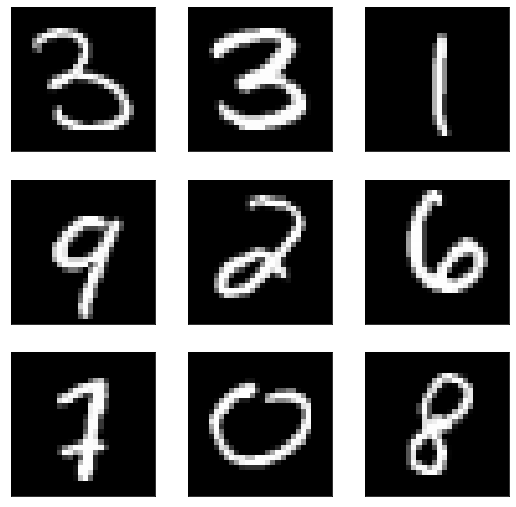

In [ ]:
# Permite visualizar algumas imagens do conjunto de teste
visualize(x_test_origin)

In [ ]:
# salvar uma imagem de cada classe para ser a ancora
salvar_ancoras(x_test_origin, y_test_origin)

Para classificar um imagem como pertencente a uma das classe, o processo é dividido em 4 fasses: \

1 - uma imagem representando cada classe é codificada. \

2 - a imagem que sera classifica é codificada. \

3 - verifica a distancia da imagem codificada na fasse 2 com cada uma das imagens codificadas na fasse 1. \

4 - a imagem sera classificada de acordo com a menor distancia encontrada na fasse 3.


In [ ]:
embedding_model = tf.keras.models.load_model("/content/embedding_model.h5")

In [ ]:
database = prepare_database(embedding_model)
saida = []

for i in range(15): # o maximo é 10000
  classe = recognise_class(x_test_origin[i], database, embedding_model)
  print("id {2}:: Classe Real: {0} >> Classe Prevista: {1}".format(y_test_origin[i], classe, i))
  saida.append([y_test_origin[i], classe])

metricas(saida) 

In [ ]:
imagens = cv2.imread("/content/temp.jpg", 0)

database = prepare_database(embedding_model)

classe = recognise_class(imagens, database, embedding_model)
print(classe)

In [ ]:
# verifica as imagem que deram errado
cv2.imwrite("teste.jpg",x_test_origin[7])